## Adversarial Autoencoder

In [32]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
from keras import backend as K
from keras.losses import binary_crossentropy, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
np.random.seed(0)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
reshape=True 

In [4]:
# Normalizing the values to be between 0 and 1 since the values are in gray scales 
# in between 0 and 255
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# Reshape the training and testing data to be as an one dimensional array
if reshape:
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


### AAE Network Parameters

In [7]:
original_dimensions = x_train.shape[1]
hidden_layer_size = 512
batch_size = 128
latent_dim = 2
epochs = 50

### AAE: -> Encoder - Decoder

In [8]:
# Input fed to the autoencoder is of the form of the batch size and the dimension of the image
inputs = Input(shape=(original_dimensions,), name='encoder_input')
h = Dense(hidden_layer_size, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='g_mean')(h)
z_log_sigma = Dense(latent_dim, name='g_variance')(h)

W0830 00:00:22.898559 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 00:00:22.921659 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 00:00:22.923274 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [9]:
def parametrization(args):
    # REPARAMETRIZATION TRICK
    m, v = args
    epsilon = tf.random.normal(shape=(2,))
    return m + K.exp(0.5 * v) * epsilon

In [10]:
# Get the combined z value from the function using the mean and sigma learnt by the autoencoder
z = Lambda(parametrization)([z_mean, z_log_sigma])
# encoder, from inputs to latent space
encoder = Model(inputs, z)

In [11]:
decoder_h = Dense(hidden_layer_size, activation='relu', name='decode_intermediate')
decoder_mean = Dense(original_dimensions, activation='sigmoid', name='decode_full')
# Same dimensions of the layers as the encoders but takes in the opposite way - as the autoencoder should
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [12]:
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [13]:
# end-to-end autoencoder - defining the input and output points
vae = Model(inputs, x_decoded_mean)

### It is just the reconstruction phase, where only the encoder and decoder loss is calculated

In [14]:
def total_loss(x, x_decoded_mean):
    rcons_loss = mean_squared_error(x, x_decoded_mean)
    rcons_loss *= original_dimensions
    return rcons_loss

vae.compile(optimizer='adam', loss=total_loss)

W0830 00:00:24.859153 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [15]:
x_decoded_mean.shape

TensorShape([Dimension(None), Dimension(784)])

In [16]:
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [17]:
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
decode_intermediate (Dense)  (None, 512)               1536      
_________________________________________________________________
decode_full (Dense)          (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [18]:
vae.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
g_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
g_variance (Dense)              (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

In [19]:
# Fit the model to the data but labels and data would be the same since it is a generative model
# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.fit(x_train,x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

W0830 00:00:28.277132 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0830 00:00:28.463806 4420507072 deprecation_wrapper.py:119] From /Users/harshdeep/final3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 172us/step - loss: 49.0197 - val_loss: 40.5777
Epoch 2/50
60000/60000 [==============================] - 10s 163us/step - loss: 38.5994 - val_loss: 36.9796
Epoch 3/50
60000/60000 [==============================] - 10s 162us/step - loss: 36.3379 - val_loss: 35.6424
Epoch 4/50
60000/60000 [==============================] - 10s 171us/step - loss: 35.1273 - val_loss: 34.8562
Epoch 5/50
60000/60000 [==============================] - 10s 166us/step - loss: 34.3465 - val_loss: 34.1879
Epoch 6/50
60000/60000 [==============================] - 11s 178us/step - loss: 33.7233 - val_loss: 33.5700
Epoch 7/50
60000/60000 [==============================] - 10s 159us/step - loss: 33.2290 - val_loss: 33.1714
Epoch 8/50
60000/60000 [==============================] - 9s 150us/step - loss: 32.7904 - val_loss: 32.8727
Epoch 9/50
60000/60000 [==============================] - 9s 143us/step - loss:

In [21]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded.shape

(10000, 2)

In [22]:
# display a 2D manifold of the digits
n = 15  # number of digits to be generated
digit_size = 28 # Size of the digits
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        
        # Looking in the Z-sample space with the dimensions for x and y
        # 0.2 is basically trying to bound the set of items you can intake - so it is a parameter
        z_sample = np.array([[xi, yi]]) * 0.2
        # Put the values of the Z sample space in the decoder
        x_decoded = generator.predict(z_sample)
        # Reshape the digit into 28*28 - 2D thingy!
        digit = x_decoded[0].reshape(digit_size, digit_size)
        # Assign the digit into the output set 
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

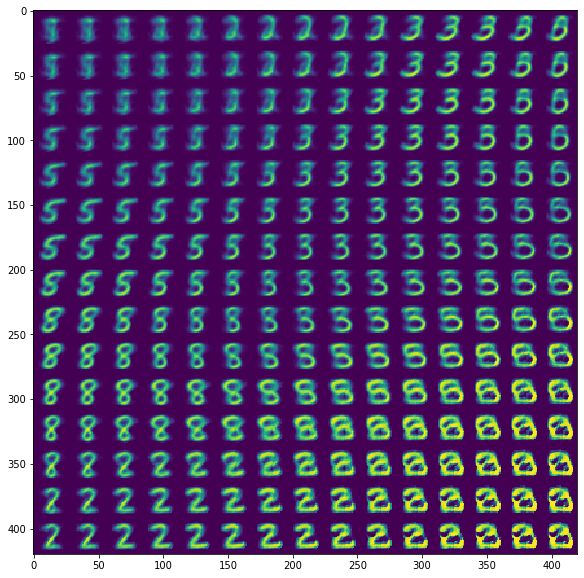

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

## Regularization phase

### Step 1 of Regularization

First, we train the discriminator to classify the encoder output (z) and some random input - z'. For example, the random input can be normally distributed with a mean of 0 and standard deviation of 1.


So, the discriminator should give us an output 1 if we pass in random inputs with the desired distribution (real values) and should give us an output 0 (fake values) when we pass in the encoder output. Intuitively, both the encoder output and the random inputs to the discriminator should have the same size.

In [34]:
# Add the discriminator for 
# Input fed to the autoencoder is of the form of the size of the latent dimensions
d_inputs = Input(shape=(latent_dim,), name='discriminator_input')
d_h = Dense(1000, activation='relu')(d_inputs)
d_h_two = Dense(1000, activation='relu')(d_h)
real_or_fake = Dense(1, activation='sigmoid')(d_h_two)

In [35]:
discriminator = Model(d_inputs, real_or_fake)
discriminator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 1001      
Total params: 1,005,001
Trainable params: 1,005,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
discriminator.trainable = False

In [38]:
valid = discriminator(encoder(inputs))
encoder_discriminator = Model(inputs, valid)

In [39]:
encoder_discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
half_batch = int(batch_size / 2)
for epoch in tqdm_notebook(range(2000)):
    #---------------Train Discriminator -------------
    # Select a random half batch of images
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    imgs = x_train[idx]
    # Generate a half batch of new images
    latent_fake = encoder.predict(imgs)
    latent_real = 6 * np.random.normal(size=(half_batch, latent_dim))
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(latent_real, valid)
    d_loss_fake = discriminator.train_on_batch(latent_fake, fake)

    idx = np.random.randint(0, x_train.shape[0], batch_size)
    imgs = x_train[idx]
    # Generator wants the discriminator to label the generated representations as valid
    valid_y = np.ones((batch_size, 1))

    # Train generator
    g_logg_similarity = encoder_discriminator.train_on_batch(imgs, valid_y)
    
    if epoch % 50 == 0:
        print('For DISCRIMINATOR epoch: {} - REAL loss is: {} -- FAKE loss is : {}'.format(
            epoch, d_loss_real, d_loss_fake))
        print('For GENERATOR epoch: {} loss is: {}'.format(epoch, g_logg_similarity))

For DISCRIMINATOR epoch: 0 - REAL loss is: [0.7626107, 0.21875] -- FAKE loss is : [2.816361, 0.0]
For GENERATOR epoch: 0 loss is: [0.21755745, 1.0]
For DISCRIMINATOR epoch: 50 - REAL loss is: [0.6475061, 0.609375] -- FAKE loss is : [0.774451, 0.28125]
For GENERATOR epoch: 50 loss is: [0.6494963, 0.6953125]
For DISCRIMINATOR epoch: 100 - REAL loss is: [0.6924186, 0.4375] -- FAKE loss is : [0.6875962, 0.5625]
For GENERATOR epoch: 100 loss is: [0.72532415, 0.4296875]
For DISCRIMINATOR epoch: 150 - REAL loss is: [0.7496773, 0.28125] -- FAKE loss is : [0.5920516, 0.875]
For GENERATOR epoch: 150 loss is: [0.79212886, 0.1953125]
For DISCRIMINATOR epoch: 200 - REAL loss is: [0.7009101, 0.515625] -- FAKE loss is : [0.69305116, 0.484375]
For GENERATOR epoch: 200 loss is: [0.72584784, 0.328125]
For DISCRIMINATOR epoch: 250 - REAL loss is: [0.72957677, 0.4375] -- FAKE loss is : [0.6390766, 0.65625]
For GENERATOR epoch: 250 loss is: [1.0998585, 0.1875]
For DISCRIMINATOR epoch: 300 - REAL loss is: [

In [41]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded.shape

(10000, 2)

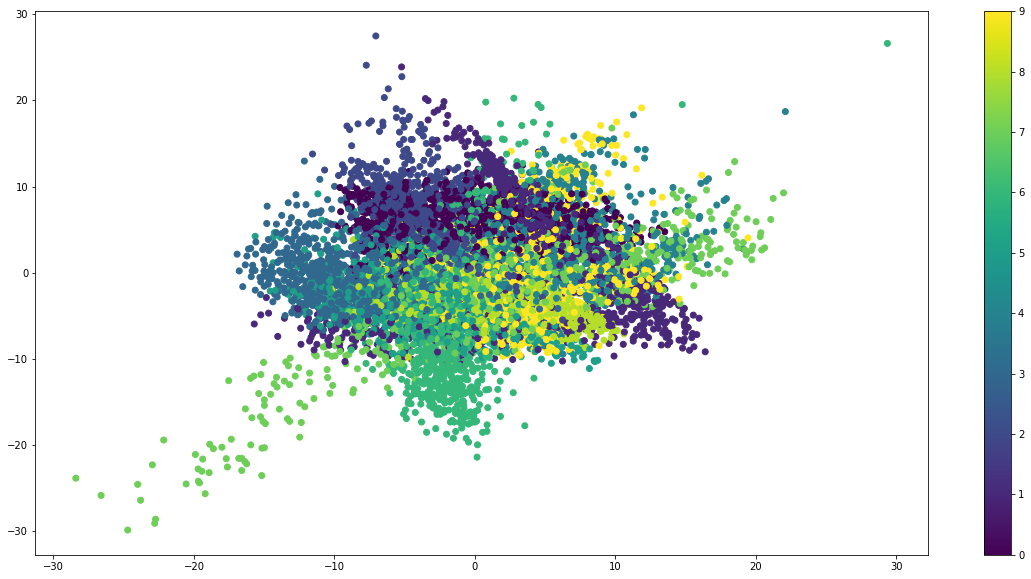

In [44]:
plt.figure(figsize=(20, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()